In [1]:
# without Hyperparameter tuning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from category_encoders import LeaveOneOutEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("cleaned.csv") 
print("✅ Dataset loaded:", df.shape)

# Define columns
categorical_cols = ['Crop_Type', 'Soil_Type']
numerical_cols = ['Soil_pH', 'Soil_Quality', 'N', 'P', 'K',
                  'Wind_Speed', 'Temperature', 'Humidity']
target_col = 'Crop_Yield'

X = df[categorical_cols + numerical_cols]
y = df[target_col]

X[categorical_cols] = X[categorical_cols].astype(str).fillna("Unknown")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"📊 Train shape: {X_train.shape}, Test shape: {X_test.shape}")

rf_pipeline = Pipeline([
    ('encoder', LeaveOneOutEncoder(cols=categorical_cols, sigma=0.05)),
    ('model', RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1
    ))
])

print("\n🚀 Training Random Forest with LOO Encoding...")
rf_pipeline.fit(X_train, y_train)

y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n📊 Random Forest Performance (LOO Encoding, No Tuning)")
print(f"Training → R²: {train_r2:.6f}, RMSE: {train_rmse:.6f}, MAE: {train_mae:.6f}")
print(f"Testing  → R²: {test_r2:.6f}, RMSE: {test_rmse:.6f}, MAE: {test_mae:.6f}")



✅ Dataset loaded: (25443, 11)
📊 Train shape: (20354, 10), Test shape: (5089, 10)

🚀 Training Random Forest with LOO Encoding...

📊 Random Forest Performance (LOO Encoding, No Tuning)
Training → R²: 0.975908, RMSE: 3.463932, MAE: 2.342053
Testing  → R²: 0.956270, RMSE: 4.702063, MAE: 3.318725


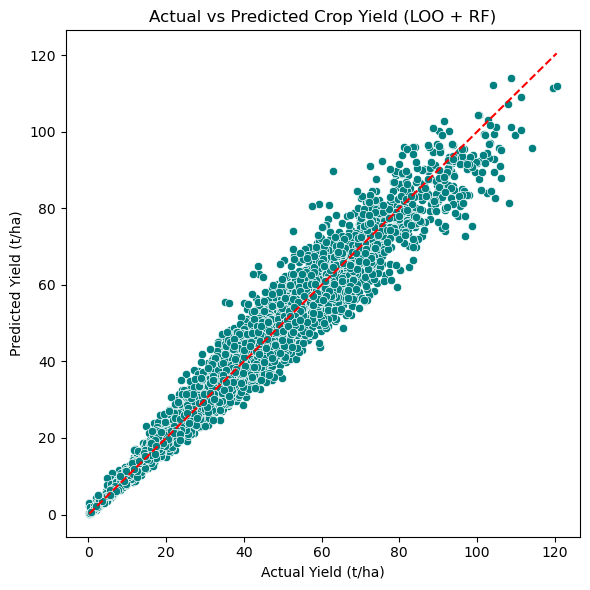

In [2]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_test_pred, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Crop Yield (LOO + RF)")
plt.xlabel("Actual Yield (t/ha)")
plt.ylabel("Predicted Yield (t/ha)")
plt.tight_layout()
plt.show()


In [3]:
# ==================== Save Model =====================
joblib.dump(rf_pipeline, "bestmodel.pkl")
# Save feature order for consistent future predictions
feature_order = X_train.columns.tolist()
joblib.dump(feature_order, "feature_order.pkl")

['feature_order.pkl']

In [4]:
# ===============================================================
# 🌾 AGRIYIELD PREDICTION SCRIPT (Using Saved LOO + RF Pipeline)
# ===============================================================

import pandas as pd
import joblib

def predict_crop_yield(model_path, feature_order_path, new_data):
    """
    Predict crop yield safely using a trained model and feature order.
    - model_path: path to saved .pkl model
    - feature_order_path: path to saved feature order file
    - new_data: dictionary containing input values for all features
    """

    # ==================== Load Model & Feature Order ====================
    print("📦 Loading trained model and feature order...")
    model = joblib.load(model_path)
    feature_order = joblib.load(feature_order_path)

    # ==================== Prepare New Data ====================
    # Convert dictionary to DataFrame
    new_df = pd.DataFrame([new_data])

    # Ensure all required columns exist
    missing_cols = set(feature_order) - set(new_df.columns)
    for col in missing_cols:
        new_df[col] = 0  # Fill missing columns with 0

    # Reorder columns to match the training feature order
    new_df = new_df[feature_order]

    print("\n🧩 Final Input to Model:")
    print(new_df.head())

    # ==================== Make Prediction ====================
    prediction = model.predict(new_df)[0]

    print(f"\n🌾 Predicted Crop Yield: {prediction:.3f} tonnes/hectare")
    return prediction


# ===============================================================
# 🧪 Example Usage
# ===============================================================
if __name__ == "__main__":
    # Paths to your saved model & feature order
    model_path = "bestmodel.pkl"
    feature_order_path = "feature_order.pkl"

    # Example input (LOO encoder handles categorical features automatically)
    new_crop_data = {
        'Crop_Type': 'Wheat',
        'Soil_Type': 'Loamy',
        'Soil_pH': 6.7,
        'Soil_Quality': 75,
        'N': 42,
        'P': 36,
        'K': 22,
        'Wind_Speed': 11.5,
        'Temperature': 29.8,
        'Humidity': 73.2
    }

    # Perform prediction
    predict_crop_yield(model_path, feature_order_path, new_crop_data)


📦 Loading trained model and feature order...

🧩 Final Input to Model:
  Crop_Type Soil_Type  Soil_pH  Soil_Quality   N   P   K  Wind_Speed  \
0     Wheat     Loamy      6.7            75  42  36  22        11.5   

   Temperature  Humidity  
0         29.8      73.2  

🌾 Predicted Crop Yield: 30.600 tonnes/hectare


In [5]:
if __name__ == "__main__":
    # Paths to your saved model & feature order
    model_path = "bestmodel.pkl"
    feature_order_path = "feature_order.pkl"

    # Example input (LOO encoder handles categorical features automatically)
    new_crop_data = {
        'Crop_Type': 'Potato',
        'Soil_Type': 'Peaty',
        'Soil_pH': 5.5,
        'Soil_Quality': 22.85,
        'N': 60,
        'P': 45,
        'K': 31.5,
        'Wind_Speed': 10.96,
        'Temperature': 11.08,
        'Humidity': 80.0
    }

    # Perform prediction
    predict_crop_yield(model_path, feature_order_path, new_crop_data)


📦 Loading trained model and feature order...

🧩 Final Input to Model:
  Crop_Type Soil_Type  Soil_pH  Soil_Quality   N   P     K  Wind_Speed  \
0    Potato     Peaty      5.5         22.85  60  45  31.5       10.96   

   Temperature  Humidity  
0        11.08      80.0  

🌾 Predicted Crop Yield: 6.063 tonnes/hectare


In [6]:
if __name__ == "__main__":
    # Paths to your saved model & feature order
    model_path = "bestmodel.pkl"
    feature_order_path = "feature_order.pkl"

    # Example input (LOO encoder handles categorical features automatically)
    new_crop_data = {
        'Crop_Type': 'Cotton',
        'Soil_Type': 'Clay',
        'Soil_pH': 6.25,
        'Soil_Quality': 49.29,
        'N': 66,
        'P': 55,
        'K': 48,
        'Wind_Speed': 3.67,
        'Temperature': 19.54,
        'Humidity': 80
    }

    # Perform prediction
    predict_crop_yield(model_path, feature_order_path, new_crop_data)


📦 Loading trained model and feature order...

🧩 Final Input to Model:
  Crop_Type Soil_Type  Soil_pH  Soil_Quality   N   P   K  Wind_Speed  \
0    Cotton      Clay     6.25         49.29  66  55  48        3.67   

   Temperature  Humidity  
0        19.54        80  

🌾 Predicted Crop Yield: 73.513 tonnes/hectare


In [7]:
new_crop_data = {
    'Crop_Type': 'Wheat',
    'Soil_Type': 'Loamy',
    'Soil_pH': 6.5,
    'Soil_Quality': 70,
    'N': 40, 'P': 35, 'K': 22,
    'Wind_Speed': 12.3,
    'Temperature': 30.2,
    'Humidity': 75.4,
    'Tem_per_Wspeed': 2.5
}
predict_crop_yield(model_path,feature_order_path,new_crop_data)

📦 Loading trained model and feature order...

🧩 Final Input to Model:
  Crop_Type Soil_Type  Soil_pH  Soil_Quality   N   P   K  Wind_Speed  \
0     Wheat     Loamy      6.5            70  40  35  22        12.3   

   Temperature  Humidity  
0         30.2      75.4  

🌾 Predicted Crop Yield: 31.633 tonnes/hectare


np.float64(31.632786816663714)